# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

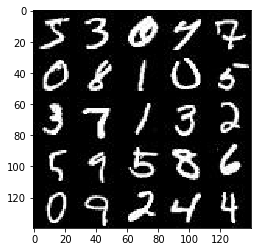

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

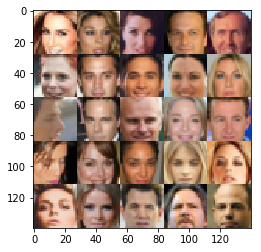

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


D:\Program Files (x86)\anaconda\envs\seq2seq\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(shape=[None,image_width,image_height,image_channels],dtype=tf.float32,name='input_real')
    inputs_z=tf.placeholder(shape=[None,z_dim],dtype=tf.float32,name='input_z')
    learning_rate=tf.placeholder(dtype=tf.float32,name='lr',shape=())
    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #conv1
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.maximum(x1,0.2*x1)
        #14*14*64
        
        #conv2
        x2=tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(x2,0.2*x2)
        #7*7*128
        
        #conv3
        x3=tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())#4*4*256
        logits=tf.layers.dense(tf.reshape(x3,(-1,4*4*256)),1) #fully-connected
        output=tf.nn.sigmoid(logits)
        
    return  output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=not is_train
    with tf.variable_scope('generator',reuse=reuse):
        
        x1=tf.layers.dense(z,(7*7*512))
        x1=tf.reshape(x1,(-1,7,7,512))
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(x1,0.2*x1)
        #7*7*512
        
        #conv1
        x2=tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(x2,0.2*x2)
        #14*14*256
        
        
        #conv2
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        output=0.5*tf.tanh(logits)
        #28*28*out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_real_output,d_real_logits=discriminator(input_real)
    d_fake_output,d_fake_logits=discriminator(g_model,True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_output)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_output)))
    d_loss=d_loss_real+d_loss_fake
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_output)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith('discriminator')]
    g_vars=[var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    inputs_real,inputs_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z,data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d,train_loss_g = d_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate}) ,g_loss.eval({inputs_z: batch_z,inputs_real: batch_images,lr:learning_rate})
                    print("Epoch {}/{}...".format(steps, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, inputs_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 10/0... Discriminator Loss: 2.9460... Generator Loss: 0.1246
Epoch 20/0... Discriminator Loss: 2.5618... Generator Loss: 0.2246
Epoch 30/0... Discriminator Loss: 2.7060... Generator Loss: 0.1339
Epoch 40/0... Discriminator Loss: 2.1211... Generator Loss: 0.3344
Epoch 50/0... Discriminator Loss: 2.0428... Generator Loss: 0.6271
Epoch 60/0... Discriminator Loss: 2.0493... Generator Loss: 0.5300
Epoch 70/0... Discriminator Loss: 2.0447... Generator Loss: 0.3191
Epoch 80/0... Discriminator Loss: 1.9278... Generator Loss: 0.5731
Epoch 90/0... Discriminator Loss: 1.9388... Generator Loss: 0.5232
Epoch 100/0... Discriminator Loss: 1.8896... Generator Loss: 0.2889


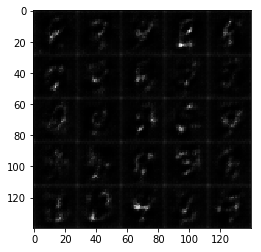

Epoch 110/0... Discriminator Loss: 1.9211... Generator Loss: 0.7034
Epoch 120/0... Discriminator Loss: 1.8975... Generator Loss: 0.6828
Epoch 130/0... Discriminator Loss: 1.8479... Generator Loss: 0.4606
Epoch 140/0... Discriminator Loss: 2.0466... Generator Loss: 0.4883
Epoch 150/0... Discriminator Loss: 1.8040... Generator Loss: 0.4227
Epoch 160/0... Discriminator Loss: 1.7810... Generator Loss: 0.5300
Epoch 170/0... Discriminator Loss: 2.1335... Generator Loss: 0.2315
Epoch 180/0... Discriminator Loss: 1.7119... Generator Loss: 0.3916
Epoch 190/0... Discriminator Loss: 1.5181... Generator Loss: 0.7381
Epoch 200/0... Discriminator Loss: 1.7590... Generator Loss: 0.3604


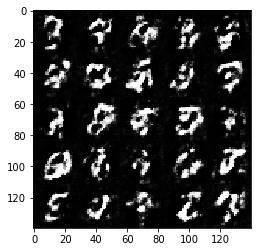

Epoch 210/0... Discriminator Loss: 1.7039... Generator Loss: 0.6324
Epoch 220/0... Discriminator Loss: 1.4280... Generator Loss: 0.6542
Epoch 230/0... Discriminator Loss: 1.6664... Generator Loss: 0.3855
Epoch 240/0... Discriminator Loss: 1.5862... Generator Loss: 0.4880
Epoch 250/0... Discriminator Loss: 1.6726... Generator Loss: 0.4715
Epoch 260/0... Discriminator Loss: 1.4188... Generator Loss: 0.6482
Epoch 270/0... Discriminator Loss: 1.6016... Generator Loss: 0.5098
Epoch 280/0... Discriminator Loss: 1.4747... Generator Loss: 0.7551
Epoch 290/0... Discriminator Loss: 1.9099... Generator Loss: 0.2647
Epoch 300/0... Discriminator Loss: 1.7556... Generator Loss: 0.3358


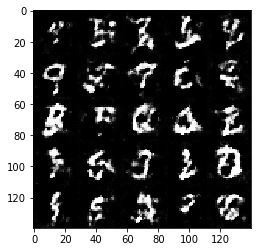

Epoch 310/0... Discriminator Loss: 1.6096... Generator Loss: 0.4158
Epoch 320/0... Discriminator Loss: 1.5936... Generator Loss: 0.8937
Epoch 330/0... Discriminator Loss: 1.5170... Generator Loss: 0.8278
Epoch 340/0... Discriminator Loss: 1.5238... Generator Loss: 0.6053
Epoch 350/0... Discriminator Loss: 1.4830... Generator Loss: 0.6818
Epoch 360/0... Discriminator Loss: 1.7088... Generator Loss: 0.4445
Epoch 370/0... Discriminator Loss: 1.6456... Generator Loss: 0.6168
Epoch 380/0... Discriminator Loss: 1.6028... Generator Loss: 0.4576
Epoch 390/0... Discriminator Loss: 1.5395... Generator Loss: 0.4631
Epoch 400/0... Discriminator Loss: 2.4302... Generator Loss: 0.1572


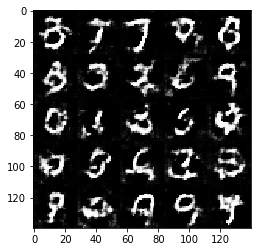

Epoch 410/0... Discriminator Loss: 1.8591... Generator Loss: 0.3168
Epoch 420/0... Discriminator Loss: 1.4206... Generator Loss: 0.5970
Epoch 430/0... Discriminator Loss: 1.4386... Generator Loss: 1.1799
Epoch 440/0... Discriminator Loss: 1.6540... Generator Loss: 0.7998
Epoch 450/0... Discriminator Loss: 1.7196... Generator Loss: 0.4062
Epoch 460/0... Discriminator Loss: 1.5815... Generator Loss: 0.5058
Epoch 470/0... Discriminator Loss: 1.6985... Generator Loss: 0.4583
Epoch 480/0... Discriminator Loss: 1.5031... Generator Loss: 0.5402
Epoch 490/0... Discriminator Loss: 1.7706... Generator Loss: 0.3804
Epoch 500/0... Discriminator Loss: 1.6878... Generator Loss: 0.4210


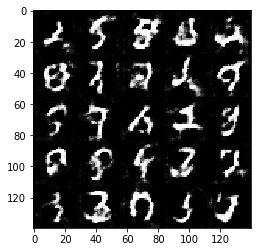

Epoch 510/0... Discriminator Loss: 1.6015... Generator Loss: 0.9774
Epoch 520/0... Discriminator Loss: 1.5056... Generator Loss: 0.6667
Epoch 530/0... Discriminator Loss: 1.6569... Generator Loss: 0.4671
Epoch 540/0... Discriminator Loss: 1.6211... Generator Loss: 0.4284
Epoch 550/0... Discriminator Loss: 1.6562... Generator Loss: 1.5084
Epoch 560/0... Discriminator Loss: 1.5745... Generator Loss: 0.8351
Epoch 570/0... Discriminator Loss: 1.5983... Generator Loss: 0.5772
Epoch 580/0... Discriminator Loss: 1.5120... Generator Loss: 0.6171
Epoch 590/0... Discriminator Loss: 1.4981... Generator Loss: 0.9502
Epoch 600/0... Discriminator Loss: 1.7341... Generator Loss: 0.3762


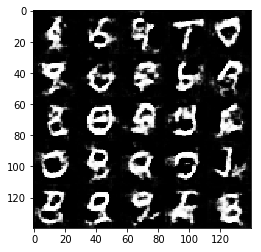

Epoch 610/0... Discriminator Loss: 1.5773... Generator Loss: 0.4933
Epoch 620/0... Discriminator Loss: 1.4998... Generator Loss: 0.5940
Epoch 630/0... Discriminator Loss: 1.5712... Generator Loss: 0.5474
Epoch 640/0... Discriminator Loss: 1.5281... Generator Loss: 0.4618
Epoch 650/0... Discriminator Loss: 1.6402... Generator Loss: 0.5791
Epoch 660/0... Discriminator Loss: 1.7194... Generator Loss: 0.3847
Epoch 670/0... Discriminator Loss: 1.8241... Generator Loss: 1.2782
Epoch 680/0... Discriminator Loss: 1.6198... Generator Loss: 0.6740
Epoch 690/0... Discriminator Loss: 1.6017... Generator Loss: 0.6675
Epoch 700/0... Discriminator Loss: 1.2877... Generator Loss: 1.0765


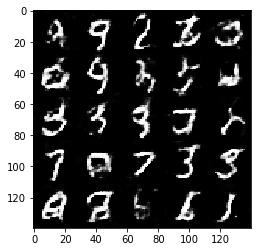

Epoch 710/0... Discriminator Loss: 1.8983... Generator Loss: 0.3355
Epoch 720/0... Discriminator Loss: 1.5946... Generator Loss: 0.5392
Epoch 730/0... Discriminator Loss: 1.5294... Generator Loss: 0.4892
Epoch 740/0... Discriminator Loss: 1.6195... Generator Loss: 0.6362
Epoch 750/0... Discriminator Loss: 1.7057... Generator Loss: 0.4185
Epoch 760/0... Discriminator Loss: 1.3149... Generator Loss: 1.2630
Epoch 770/0... Discriminator Loss: 1.4626... Generator Loss: 0.6737
Epoch 780/0... Discriminator Loss: 1.6794... Generator Loss: 0.8969
Epoch 790/0... Discriminator Loss: 1.6477... Generator Loss: 0.4734
Epoch 800/0... Discriminator Loss: 1.8377... Generator Loss: 0.3600


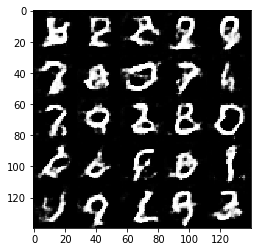

Epoch 810/0... Discriminator Loss: 1.7111... Generator Loss: 0.3784
Epoch 820/0... Discriminator Loss: 1.6880... Generator Loss: 0.4299
Epoch 830/0... Discriminator Loss: 1.8651... Generator Loss: 0.3023
Epoch 840/0... Discriminator Loss: 1.3693... Generator Loss: 0.9398
Epoch 850/0... Discriminator Loss: 1.5600... Generator Loss: 0.4275
Epoch 860/0... Discriminator Loss: 1.5070... Generator Loss: 0.6403
Epoch 870/0... Discriminator Loss: 1.4920... Generator Loss: 0.7394
Epoch 880/0... Discriminator Loss: 1.8212... Generator Loss: 0.2949
Epoch 890/0... Discriminator Loss: 1.5117... Generator Loss: 0.6968
Epoch 900/0... Discriminator Loss: 1.5167... Generator Loss: 0.4842


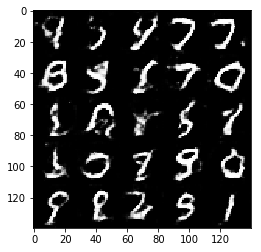

Epoch 910/0... Discriminator Loss: 1.5557... Generator Loss: 0.5828
Epoch 920/0... Discriminator Loss: 1.7093... Generator Loss: 0.3502
Epoch 930/0... Discriminator Loss: 1.6516... Generator Loss: 0.4270
Epoch 940/0... Discriminator Loss: 1.5402... Generator Loss: 0.4715
Epoch 950/0... Discriminator Loss: 1.5648... Generator Loss: 1.3632
Epoch 960/0... Discriminator Loss: 1.3682... Generator Loss: 0.6620


KeyboardInterrupt: 

In [21]:
batch_size =32 #None
z_dim =128 #None
learning_rate =0.0002 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 10/0... Discriminator Loss: 4.1102... Generator Loss: 0.0332
Epoch 20/0... Discriminator Loss: 3.6937... Generator Loss: 0.0547
Epoch 30/0... Discriminator Loss: 3.7851... Generator Loss: 0.0446
Epoch 40/0... Discriminator Loss: 2.9414... Generator Loss: 0.1717
Epoch 50/0... Discriminator Loss: 3.1651... Generator Loss: 0.0963
Epoch 60/0... Discriminator Loss: 2.9983... Generator Loss: 0.1500
Epoch 70/0... Discriminator Loss: 2.5014... Generator Loss: 0.1989
Epoch 80/0... Discriminator Loss: 2.4876... Generator Loss: 0.2244
Epoch 90/0... Discriminator Loss: 2.3370... Generator Loss: 0.3041
Epoch 100/0... Discriminator Loss: 2.1698... Generator Loss: 0.2488


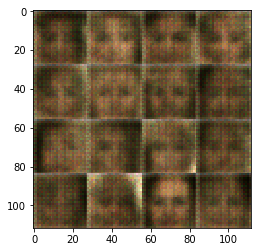

Epoch 110/0... Discriminator Loss: 2.2299... Generator Loss: 0.2363
Epoch 120/0... Discriminator Loss: 2.2272... Generator Loss: 0.2548
Epoch 130/0... Discriminator Loss: 2.1191... Generator Loss: 0.3031
Epoch 140/0... Discriminator Loss: 2.2063... Generator Loss: 0.2864
Epoch 150/0... Discriminator Loss: 2.3025... Generator Loss: 0.3062
Epoch 160/0... Discriminator Loss: 1.8614... Generator Loss: 0.4560
Epoch 170/0... Discriminator Loss: 1.8480... Generator Loss: 0.4725
Epoch 180/0... Discriminator Loss: 2.0962... Generator Loss: 0.3736
Epoch 190/0... Discriminator Loss: 1.9199... Generator Loss: 0.3789
Epoch 200/0... Discriminator Loss: 1.9322... Generator Loss: 0.3860


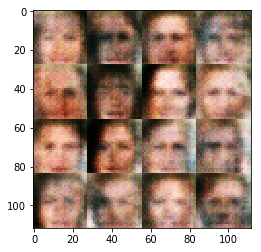

Epoch 210/0... Discriminator Loss: 1.8581... Generator Loss: 0.3772
Epoch 220/0... Discriminator Loss: 1.9473... Generator Loss: 0.3656
Epoch 230/0... Discriminator Loss: 2.1099... Generator Loss: 0.3145
Epoch 240/0... Discriminator Loss: 1.8447... Generator Loss: 0.4487
Epoch 250/0... Discriminator Loss: 1.5746... Generator Loss: 0.6251
Epoch 260/0... Discriminator Loss: 1.6636... Generator Loss: 0.5276
Epoch 270/0... Discriminator Loss: 1.6467... Generator Loss: 0.5417
Epoch 280/0... Discriminator Loss: 1.8046... Generator Loss: 0.4066
Epoch 290/0... Discriminator Loss: 2.0007... Generator Loss: 0.4046
Epoch 300/0... Discriminator Loss: 1.7964... Generator Loss: 0.4583


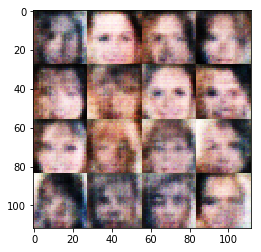

Epoch 310/0... Discriminator Loss: 1.7056... Generator Loss: 0.4798
Epoch 320/0... Discriminator Loss: 1.8793... Generator Loss: 0.4006
Epoch 330/0... Discriminator Loss: 1.6809... Generator Loss: 0.4999
Epoch 340/0... Discriminator Loss: 1.5935... Generator Loss: 0.4870
Epoch 350/0... Discriminator Loss: 1.5363... Generator Loss: 0.4733
Epoch 360/0... Discriminator Loss: 1.6235... Generator Loss: 0.4157
Epoch 370/0... Discriminator Loss: 1.0986... Generator Loss: 1.3606
Epoch 380/0... Discriminator Loss: 0.8449... Generator Loss: 1.6576
Epoch 390/0... Discriminator Loss: 0.8315... Generator Loss: 2.0772
Epoch 400/0... Discriminator Loss: 1.1812... Generator Loss: 0.7835


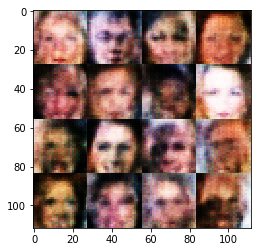

Epoch 410/0... Discriminator Loss: 0.8701... Generator Loss: 3.5908
Epoch 420/0... Discriminator Loss: 1.4725... Generator Loss: 0.4493
Epoch 430/0... Discriminator Loss: 1.6633... Generator Loss: 0.3464
Epoch 440/0... Discriminator Loss: 1.2365... Generator Loss: 1.0076
Epoch 450/0... Discriminator Loss: 1.0130... Generator Loss: 0.8312
Epoch 460/0... Discriminator Loss: 1.4039... Generator Loss: 0.5047
Epoch 470/0... Discriminator Loss: 0.6465... Generator Loss: 4.3569
Epoch 480/0... Discriminator Loss: 1.1559... Generator Loss: 0.8057
Epoch 490/0... Discriminator Loss: 1.2916... Generator Loss: 0.5881
Epoch 500/0... Discriminator Loss: 1.9130... Generator Loss: 0.2520


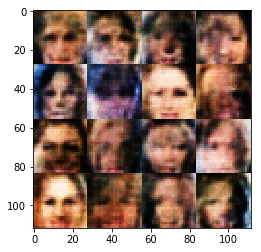

Epoch 510/0... Discriminator Loss: 0.7989... Generator Loss: 1.1289
Epoch 520/0... Discriminator Loss: 0.9622... Generator Loss: 1.2109
Epoch 530/0... Discriminator Loss: 1.2359... Generator Loss: 0.6546
Epoch 540/0... Discriminator Loss: 0.9529... Generator Loss: 1.4881
Epoch 550/0... Discriminator Loss: 1.5672... Generator Loss: 0.4953
Epoch 560/0... Discriminator Loss: 0.6110... Generator Loss: 6.5125
Epoch 570/0... Discriminator Loss: 0.8067... Generator Loss: 1.7628
Epoch 580/0... Discriminator Loss: 1.7881... Generator Loss: 0.3650
Epoch 590/0... Discriminator Loss: 1.5627... Generator Loss: 0.4997
Epoch 600/0... Discriminator Loss: 1.7995... Generator Loss: 0.2935


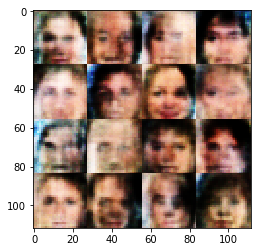

Epoch 610/0... Discriminator Loss: 1.3505... Generator Loss: 0.6135
Epoch 620/0... Discriminator Loss: 0.7437... Generator Loss: 5.1836
Epoch 630/0... Discriminator Loss: 1.8956... Generator Loss: 0.3019
Epoch 640/0... Discriminator Loss: 1.3201... Generator Loss: 1.4871
Epoch 650/0... Discriminator Loss: 0.8570... Generator Loss: 2.4902
Epoch 660/0... Discriminator Loss: 1.2689... Generator Loss: 0.6129
Epoch 670/0... Discriminator Loss: 1.3466... Generator Loss: 0.7007
Epoch 680/0... Discriminator Loss: 0.6546... Generator Loss: 4.4805
Epoch 690/0... Discriminator Loss: 0.6124... Generator Loss: 3.2047
Epoch 700/0... Discriminator Loss: 1.2240... Generator Loss: 0.8722


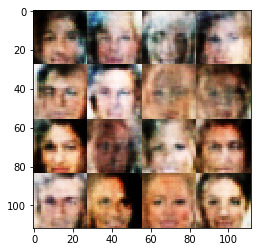

Epoch 710/0... Discriminator Loss: 2.0036... Generator Loss: 0.2615
Epoch 720/0... Discriminator Loss: 0.9962... Generator Loss: 0.9189
Epoch 730/0... Discriminator Loss: 1.4744... Generator Loss: 0.5025
Epoch 740/0... Discriminator Loss: 1.4572... Generator Loss: 0.5381
Epoch 750/0... Discriminator Loss: 1.2270... Generator Loss: 0.6272
Epoch 760/0... Discriminator Loss: 0.7601... Generator Loss: 1.3905
Epoch 770/0... Discriminator Loss: 2.3365... Generator Loss: 0.1672
Epoch 780/0... Discriminator Loss: 1.8452... Generator Loss: 0.3397
Epoch 790/0... Discriminator Loss: 1.3073... Generator Loss: 0.6520
Epoch 800/0... Discriminator Loss: 1.0586... Generator Loss: 1.2041


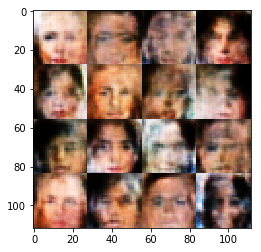

Epoch 810/0... Discriminator Loss: 1.0531... Generator Loss: 1.2253
Epoch 820/0... Discriminator Loss: 1.2765... Generator Loss: 0.6668
Epoch 830/0... Discriminator Loss: 0.7172... Generator Loss: 1.9152
Epoch 840/0... Discriminator Loss: 1.2260... Generator Loss: 1.0741
Epoch 850/0... Discriminator Loss: 0.9736... Generator Loss: 1.0444
Epoch 860/0... Discriminator Loss: 1.6326... Generator Loss: 0.3738
Epoch 870/0... Discriminator Loss: 1.0528... Generator Loss: 0.9942
Epoch 880/0... Discriminator Loss: 1.5785... Generator Loss: 0.4462
Epoch 890/0... Discriminator Loss: 1.3378... Generator Loss: 0.7242
Epoch 900/0... Discriminator Loss: 1.3569... Generator Loss: 0.5610


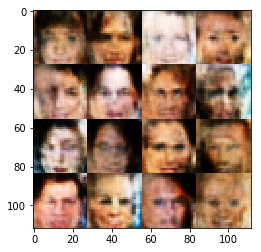

Epoch 910/0... Discriminator Loss: 0.7934... Generator Loss: 2.4006
Epoch 920/0... Discriminator Loss: 1.1516... Generator Loss: 0.8749
Epoch 930/0... Discriminator Loss: 1.2349... Generator Loss: 1.0097
Epoch 940/0... Discriminator Loss: 1.4452... Generator Loss: 0.6240
Epoch 950/0... Discriminator Loss: 0.8857... Generator Loss: 1.2252
Epoch 960/0... Discriminator Loss: 1.0527... Generator Loss: 1.1542
Epoch 970/0... Discriminator Loss: 0.6607... Generator Loss: 4.2501
Epoch 980/0... Discriminator Loss: 1.6340... Generator Loss: 0.6075
Epoch 990/0... Discriminator Loss: 0.7242... Generator Loss: 4.1704
Epoch 1000/0... Discriminator Loss: 1.7370... Generator Loss: 0.3380


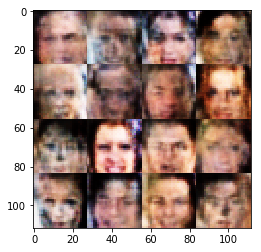

Epoch 1010/0... Discriminator Loss: 0.8835... Generator Loss: 3.0607
Epoch 1020/0... Discriminator Loss: 0.7904... Generator Loss: 2.7115
Epoch 1030/0... Discriminator Loss: 1.7471... Generator Loss: 0.3205
Epoch 1040/0... Discriminator Loss: 0.9030... Generator Loss: 1.4203
Epoch 1050/0... Discriminator Loss: 1.6226... Generator Loss: 0.4982
Epoch 1060/0... Discriminator Loss: 1.4001... Generator Loss: 0.6479
Epoch 1070/0... Discriminator Loss: 1.2645... Generator Loss: 1.0976
Epoch 1080/0... Discriminator Loss: 1.5926... Generator Loss: 0.4195
Epoch 1090/0... Discriminator Loss: 1.0743... Generator Loss: 1.1452
Epoch 1100/0... Discriminator Loss: 1.0969... Generator Loss: 1.0181


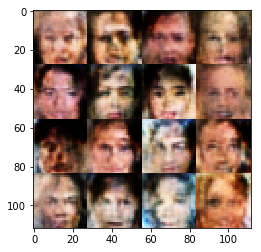

Epoch 1110/0... Discriminator Loss: 1.5566... Generator Loss: 0.5021
Epoch 1120/0... Discriminator Loss: 1.0804... Generator Loss: 1.3503
Epoch 1130/0... Discriminator Loss: 1.7848... Generator Loss: 0.3771
Epoch 1140/0... Discriminator Loss: 1.7663... Generator Loss: 0.3456
Epoch 1150/0... Discriminator Loss: 0.6215... Generator Loss: 3.6041
Epoch 1160/0... Discriminator Loss: 0.6673... Generator Loss: 1.8883
Epoch 1170/0... Discriminator Loss: 1.4205... Generator Loss: 0.7030
Epoch 1180/0... Discriminator Loss: 1.0440... Generator Loss: 1.2867
Epoch 1190/0... Discriminator Loss: 1.4092... Generator Loss: 0.5161
Epoch 1200/0... Discriminator Loss: 0.8389... Generator Loss: 4.2979


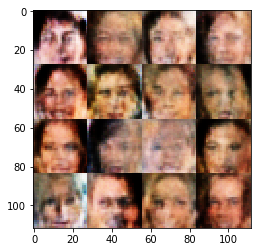

Epoch 1210/0... Discriminator Loss: 0.9770... Generator Loss: 1.5628
Epoch 1220/0... Discriminator Loss: 1.1108... Generator Loss: 0.9150
Epoch 1230/0... Discriminator Loss: 1.3091... Generator Loss: 0.5650
Epoch 1240/0... Discriminator Loss: 1.1167... Generator Loss: 1.4412
Epoch 1250/0... Discriminator Loss: 1.1347... Generator Loss: 1.3316
Epoch 1260/0... Discriminator Loss: 0.8945... Generator Loss: 2.1530
Epoch 1270/0... Discriminator Loss: 0.8088... Generator Loss: 1.8649
Epoch 1280/0... Discriminator Loss: 0.9203... Generator Loss: 3.1237
Epoch 1290/0... Discriminator Loss: 0.8229... Generator Loss: 1.6528
Epoch 1300/0... Discriminator Loss: 1.1657... Generator Loss: 0.8608


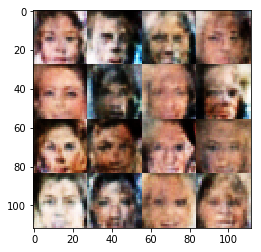

Epoch 1310/0... Discriminator Loss: 1.7795... Generator Loss: 0.4218
Epoch 1320/0... Discriminator Loss: 0.7628... Generator Loss: 1.4613
Epoch 1330/0... Discriminator Loss: 0.7596... Generator Loss: 2.0409
Epoch 1340/0... Discriminator Loss: 1.0331... Generator Loss: 1.5709
Epoch 1350/0... Discriminator Loss: 1.8636... Generator Loss: 0.3418
Epoch 1360/0... Discriminator Loss: 0.6999... Generator Loss: 2.3582
Epoch 1370/0... Discriminator Loss: 1.3574... Generator Loss: 0.7495
Epoch 1380/0... Discriminator Loss: 0.9903... Generator Loss: 1.7685
Epoch 1390/0... Discriminator Loss: 1.6439... Generator Loss: 0.3965
Epoch 1400/0... Discriminator Loss: 0.6999... Generator Loss: 3.3439


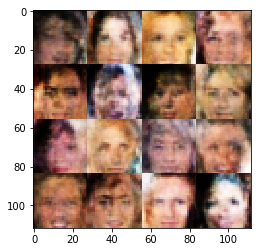

Epoch 1410/0... Discriminator Loss: 0.9504... Generator Loss: 1.1776
Epoch 1420/0... Discriminator Loss: 1.1903... Generator Loss: 0.8634
Epoch 1430/0... Discriminator Loss: 1.2504... Generator Loss: 1.0210
Epoch 1440/0... Discriminator Loss: 1.2933... Generator Loss: 0.6324
Epoch 1450/0... Discriminator Loss: 1.3522... Generator Loss: 0.7748
Epoch 1460/0... Discriminator Loss: 1.2118... Generator Loss: 1.3642
Epoch 1470/0... Discriminator Loss: 1.7491... Generator Loss: 0.3698
Epoch 1480/0... Discriminator Loss: 1.0402... Generator Loss: 2.2306
Epoch 1490/0... Discriminator Loss: 1.3255... Generator Loss: 0.5826
Epoch 1500/0... Discriminator Loss: 1.5001... Generator Loss: 0.6079


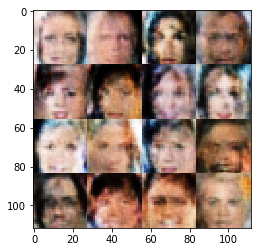

Epoch 1510/0... Discriminator Loss: 0.5790... Generator Loss: 6.3506
Epoch 1520/0... Discriminator Loss: 1.3671... Generator Loss: 0.5825
Epoch 1530/0... Discriminator Loss: 0.9554... Generator Loss: 1.6271


In [ ]:
batch_size = 16#None
z_dim =128 #None
learning_rate =0.0002 #None
beta1 =0.5 #None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.